# Load ground-truth mean agent 1 utilities

In [2]:
import json

with open('../data/rules_to_mean_agent1_utilities.json', 'r') as f:
    luds_to_mean_agent1_utilities = json.load(f)

# Investigate match simulation correlations

In [3]:
import pandas as pd

annotated_games_df = pd.read_csv('../DataGeneration/CompleteDatasets/OrganizerGamesAndFeatures_4Agents_Dedup_NoOrigLabels.csv')

lud_rules = annotated_games_df['LudRules']
match_0_outcomes = annotated_games_df['match_0_outcome']
match_1_outcomes = annotated_games_df['match_1_outcome']
match_2_outcomes = annotated_games_df['match_2_outcome']
match_3_outcomes = annotated_games_df['match_3_outcome']
mean_match_outcomes = (match_0_outcomes + match_1_outcomes + match_2_outcomes + match_3_outcomes) / 4
# mean_match_outcomes = (match_0_outcomes + match_1_outcomes + match_2_outcomes) / 3

lud_rules_to_mean_match_outcomes = dict(zip(lud_rules, mean_match_outcomes))

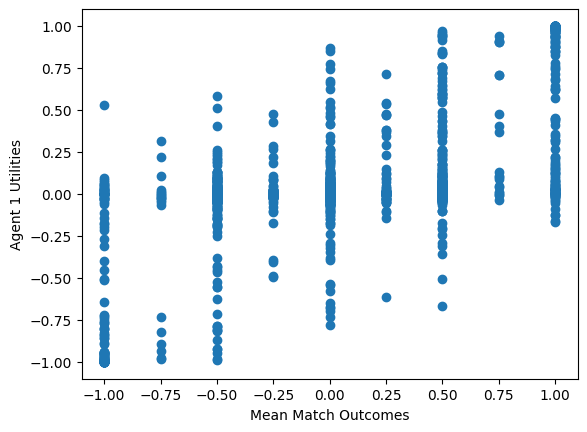

PearsonRResult(statistic=0.6475297743801868, pvalue=5.167536880769444e-164)

In [4]:
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

luds = list(luds_to_mean_agent1_utilities.keys())
agent1_utilities = [luds_to_mean_agent1_utilities[lud] for lud in luds]
mean_match_outcomes = [lud_rules_to_mean_match_outcomes[lud] for lud in luds]

plt.scatter(mean_match_outcomes, agent1_utilities)
plt.xlabel('Mean Match Outcomes')
plt.ylabel('Agent 1 Utilities')

plt.show()

pearsonr(agent1_utilities, mean_match_outcomes)

# Analyze MCTS evaluations

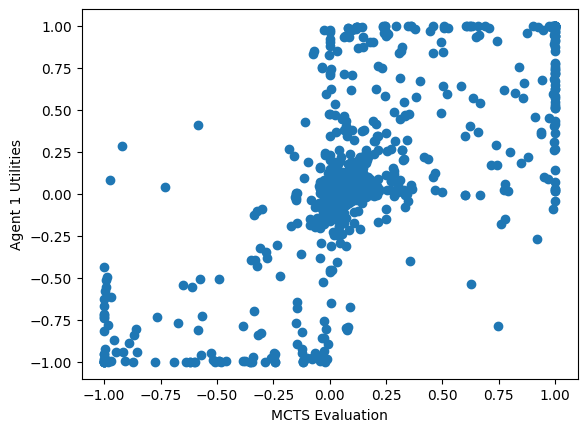

PearsonRResult(statistic=0.7155900509502419, pvalue=7.046834196159984e-216)


0.7155900509502419

In [5]:
import os
import glob
import re

def AnalyzeMctsOutcome(evaluations_directory_path: str, luds_directory_path: str, display_results = True):
    eval_filepath_pattern = os.path.join(evaluations_directory_path, '*.txt')
    eval_filepaths = glob.glob(eval_filepath_pattern)

    if len(eval_filepaths) == 0:
        return None

    luds_to_evaluations = {}
    for eval_filepath in eval_filepaths:
        # LOAD EVALUATION.
        with open(eval_filepath, 'r') as f:
            eval_file_contents = f.read()

        evaluation_pattern = r'Evaluation: (.*)'
        evaluation_match = re.search(evaluation_pattern, eval_file_contents)
        evaluation = float(evaluation_match.group(1))

        # LOAD LUD.
        lud_filename = os.path.basename(eval_filepath).replace('.txt', '.lud')
        lud_filepath = os.path.join(luds_directory_path, lud_filename)
        with open(lud_filepath, 'r') as f:
            lud = f.read()

        luds_to_evaluations[lud] = evaluation

    # ANALYZE.
    luds = list(luds_to_evaluations.keys())
    evaluations = [luds_to_evaluations[lud] for lud in luds]
    agent1_utilities = [luds_to_mean_agent1_utilities[lud] for lud in luds]

    if display_results:
        plt.scatter(evaluations, agent1_utilities)
        plt.xlabel('MCTS Evaluation')
        plt.ylabel('Agent 1 Utilities')
        plt.show()

        print(pearsonr(agent1_utilities, evaluations))

    r, p = pearsonr(agent1_utilities, evaluations)
    
    return r

AnalyzeMctsOutcome(
    evaluations_directory_path='Evaluations/OrganizerGames/MCTS-UCB1Tuned-1.41421356237-random-false/32s',
    luds_directory_path='../DataGeneration/UniqueLuds')

In [6]:
evaluation_paths = glob.glob('Evaluations/OrganizerGames/*')
series_names_to_data = {}
for evaluation_path in evaluation_paths:
    print(evaluation_path)
    for runtime_seconds in [1, 2, 4, 8, 16]:
        r = AnalyzeMctsOutcome(
            evaluations_directory_path=os.path.join(evaluation_path, f'{runtime_seconds}s'),
            luds_directory_path='../DataGeneration/UniqueLuds',
            display_results=False)
        
        print(f'{runtime_seconds}s: {r}')

        series_name = os.path.basename(evaluation_path)
        if series_name not in series_names_to_data:
            series_names_to_data[series_name] = []

        series_names_to_data[series_name].append((runtime_seconds, r))

Evaluations/OrganizerGames/MCTS-UCB1Tuned-1.41421356237-random-false
1s: 0.6070069518073797
2s: 0.62628246782854
4s: 0.6450344102672693
8s: 0.6681403253255987
16s: 0.6831450732368373
Evaluations/OrganizerGames/MCTS-ProgressiveHistory-0.6-NST-false
1s: 0.4675122115650429
2s: 0.5329586108228389
4s: 0.5154284256756868
8s: 0.5699368519129725
16s: 0.5668646147065185
Evaluations/OrganizerGames/32s
1s: None
2s: None
4s: None
8s: None
16s: None
Evaluations/OrganizerGames/2s
1s: None
2s: None
4s: None
8s: None
16s: None
Evaluations/OrganizerGames/JSON
1s: None
2s: None
4s: None
8s: None
16s: None
Evaluations/OrganizerGames/MCTS-ProgressiveHistory-0.1-NST-true
1s: None
2s: None
4s: None
8s: None
16s: None
Evaluations/OrganizerGames/4s
1s: None
2s: None
4s: None
8s: None
16s: None
Evaluations/OrganizerGames/MCTS-UCB1GRAVE-1.41421356237-MAST-true
1s: None
2s: None
4s: None
8s: None
16s: 0.4680817650580654
Evaluations/OrganizerGames/MCTS-ProgressiveHistory-1.41421356237-MAST-true
1s: 0.489266635270

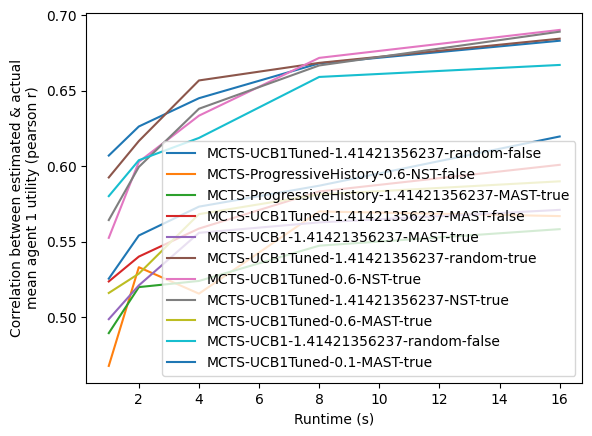

In [9]:
for series_name, data in series_names_to_data.items():
    if data[0][1] is None:
        continue

    data.sort(key=lambda x: x[0])
    plt.plot([x[0] for x in data], [x[1] for x in data], label=series_name)

plt.xlabel('Runtime (s)')
plt.ylabel('Correlation between estimated & actual\nmean agent 1 utility (pearson r)')
plt.legend(loc = 'best')

# plt.xscale('log')

plt.show()

In [8]:
for series_name, data in series_names_to_data.items():
    if data[0][1] is None:
        continue

    if data[-1][1] > 0.63:
        print(series_name)

MCTS-UCB1Tuned-1.41421356237-random-false
MCTS-UCB1Tuned-1.41421356237-random-true
MCTS-UCB1Tuned-0.6-NST-true
MCTS-UCB1Tuned-1.41421356237-NST-true
MCTS-UCB1-1.41421356237-random-false


In [9]:
for series_name, data in series_names_to_data.items():
    if data[0][1] is None:
        continue

    if data[-1][1] < 0.63:
        print(series_name)

MCTS-ProgressiveHistory-0.6-NST-false
MCTS-ProgressiveHistory-1.41421356237-MAST-true
MCTS-UCB1Tuned-1.41421356237-MAST-false
MCTS-UCB1-1.41421356237-MAST-true
MCTS-UCB1Tuned-0.6-MAST-true
MCTS-UCB1Tuned-0.1-MAST-true


# Analyze MCTS ensembles

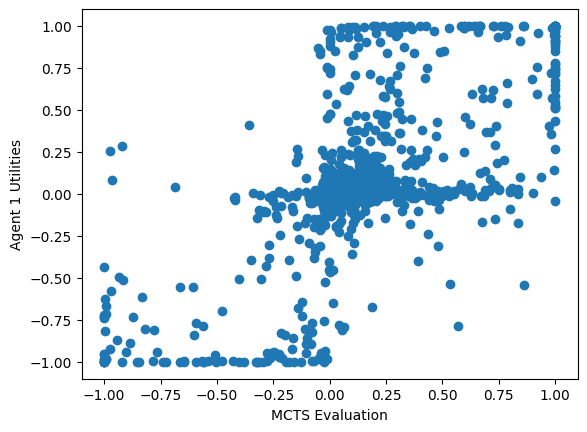

PearsonRResult(statistic=0.6680397245187127, pvalue=3.4289471695369214e-178)


0.6680397245187127

In [10]:
def AnalyzeMctsOutcome(evaluations_directory_paths: str, luds_directory_path: str, display_results = True):
    # LOAD EVALUATIONS.
    luds_to_evaluations = {}
    for evaluations_directory_path in evaluations_directory_paths:
        eval_filepath_pattern = os.path.join(evaluations_directory_path, '*.txt')
        eval_filepaths = glob.glob(eval_filepath_pattern)

        if len(eval_filepaths) == 0:
            return None

        for eval_filepath in eval_filepaths:
            # LOAD EVALUATION.
            with open(eval_filepath, 'r') as f:
                eval_file_contents = f.read()

            evaluation_pattern = r'Evaluation: (.*)'
            evaluation_match = re.search(evaluation_pattern, eval_file_contents)
            evaluation = float(evaluation_match.group(1))

            # LOAD LUD.
            lud_filename = os.path.basename(eval_filepath).replace('.txt', '.lud')
            lud_filepath = os.path.join(luds_directory_path, lud_filename)
            with open(lud_filepath, 'r') as f:
                lud = f.read()

            # RECORD EVALUATION.
            if lud not in luds_to_evaluations:
                luds_to_evaluations[lud] = []

            luds_to_evaluations[lud].append(evaluation)

    # AVERAGE EVALUATIONS.
    luds_to_evaluations = {lud: sum(evaluations) / len(evaluations) for lud, evaluations in luds_to_evaluations.items()}

    # ANALYZE.
    luds = list(luds_to_evaluations.keys())
    evaluations = [luds_to_evaluations[lud] for lud in luds]
    agent1_utilities = [luds_to_mean_agent1_utilities[lud] for lud in luds]

    if display_results:
        plt.scatter(evaluations, agent1_utilities)
        plt.xlabel('MCTS Evaluation')
        plt.ylabel('Agent 1 Utilities')
        plt.show()

        print(pearsonr(agent1_utilities, evaluations))

    r, p = pearsonr(agent1_utilities, evaluations)
    
    return r

AnalyzeMctsOutcome(
    evaluations_directory_paths=[
        'Evaluations/OrganizerGames/MCTS-UCB1Tuned-1.41421356237-random-true/4s',
        'Evaluations/OrganizerGames/MCTS-UCB1Tuned-1.41421356237-NST-true/4s',
    ],
    luds_directory_path='../DataGeneration/UniqueLuds')

# Save features

In [5]:
import glob
import re
import os
import json

# eval_filepaths = glob.glob('Evaluations/OrganizerGames/MCTS-UCB1Tuned-1.41421356237-random-false/750ms/*.txt')
eval_filepaths = glob.glob('Evaluations/OrganizerGames/MCTS-UCB1Tuned-0.6-NST-true/16s/*.txt')
luds_directory_path = '../DataGeneration/UniqueLuds'

luds_to_evaluations = {}
for eval_filepath in eval_filepaths:
    # LOAD EVALUATION.
    with open(eval_filepath, 'r') as f:
        eval_file_contents = f.read()

    evaluation_pattern = r'Evaluation: (.*)'
    evaluation_match = re.search(evaluation_pattern, eval_file_contents)
    evaluation = float(evaluation_match.group(1))

    # LOAD LUD.
    lud_filename = os.path.basename(eval_filepath).replace('.txt', '.lud')
    lud_filepath = os.path.join(luds_directory_path, lud_filename)
    with open(lud_filepath, 'r') as f:
        lud = f.read()

    luds_to_evaluations[lud] = evaluation

# output_filepath = 'Evaluations/OrganizerGames/JSON/MCTS-UCB1Tuned-1.41421356237-random-false-750ms.json'
output_filepath = 'Evaluations/OrganizerGames/JSON/MCTS-UCB1Tuned-0.6-NST-true-16s.json'
with open(output_filepath, 'w') as f:
    json.dump(luds_to_evaluations, f, indent=4)